# Fine-Tuning Vision Transformers for Image Classification through Hugging Face

The goal of this notebook is to create an image classifier for sattelite images, using hugging face (and pytorch) on the EUROSAT dataset.
We will fine-tune a Vision Transformer (ViT), as research shows this is the best approach for multi-class classification [1].

Adapted from: https://huggingface.co/blog/fine-tune-vit

In [ ]:
! pip install transformers[torch] datasets

In [ ]:
import torch
from datasets import load_dataset, DatasetDict

## Load dataset

In [38]:
ds = load_dataset('Pratha1m/euroSAT-convnext')
ds["train"] = ds["train"].rename_column("label", "labels")
ds

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 27000
    })
})

Split the dataset:

In [39]:

# 90% train, 10% test + validation
train_testvalid = ds["train"].train_test_split(0.1)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 1350
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 1350
    })
})


In [40]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

Let's inspect an example.

In [41]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7EFB667F4970>,
 'labels': 4}

Let's take a look at the image

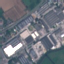

In [42]:
image = ex['image']
image

And its label.

In [43]:
labels.int2str(ex['labels'])

'Industrial'

Display a grid of examples from each class so we can get a better idea of what we're working with.

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24300 [00:00<?, ? examples/s]

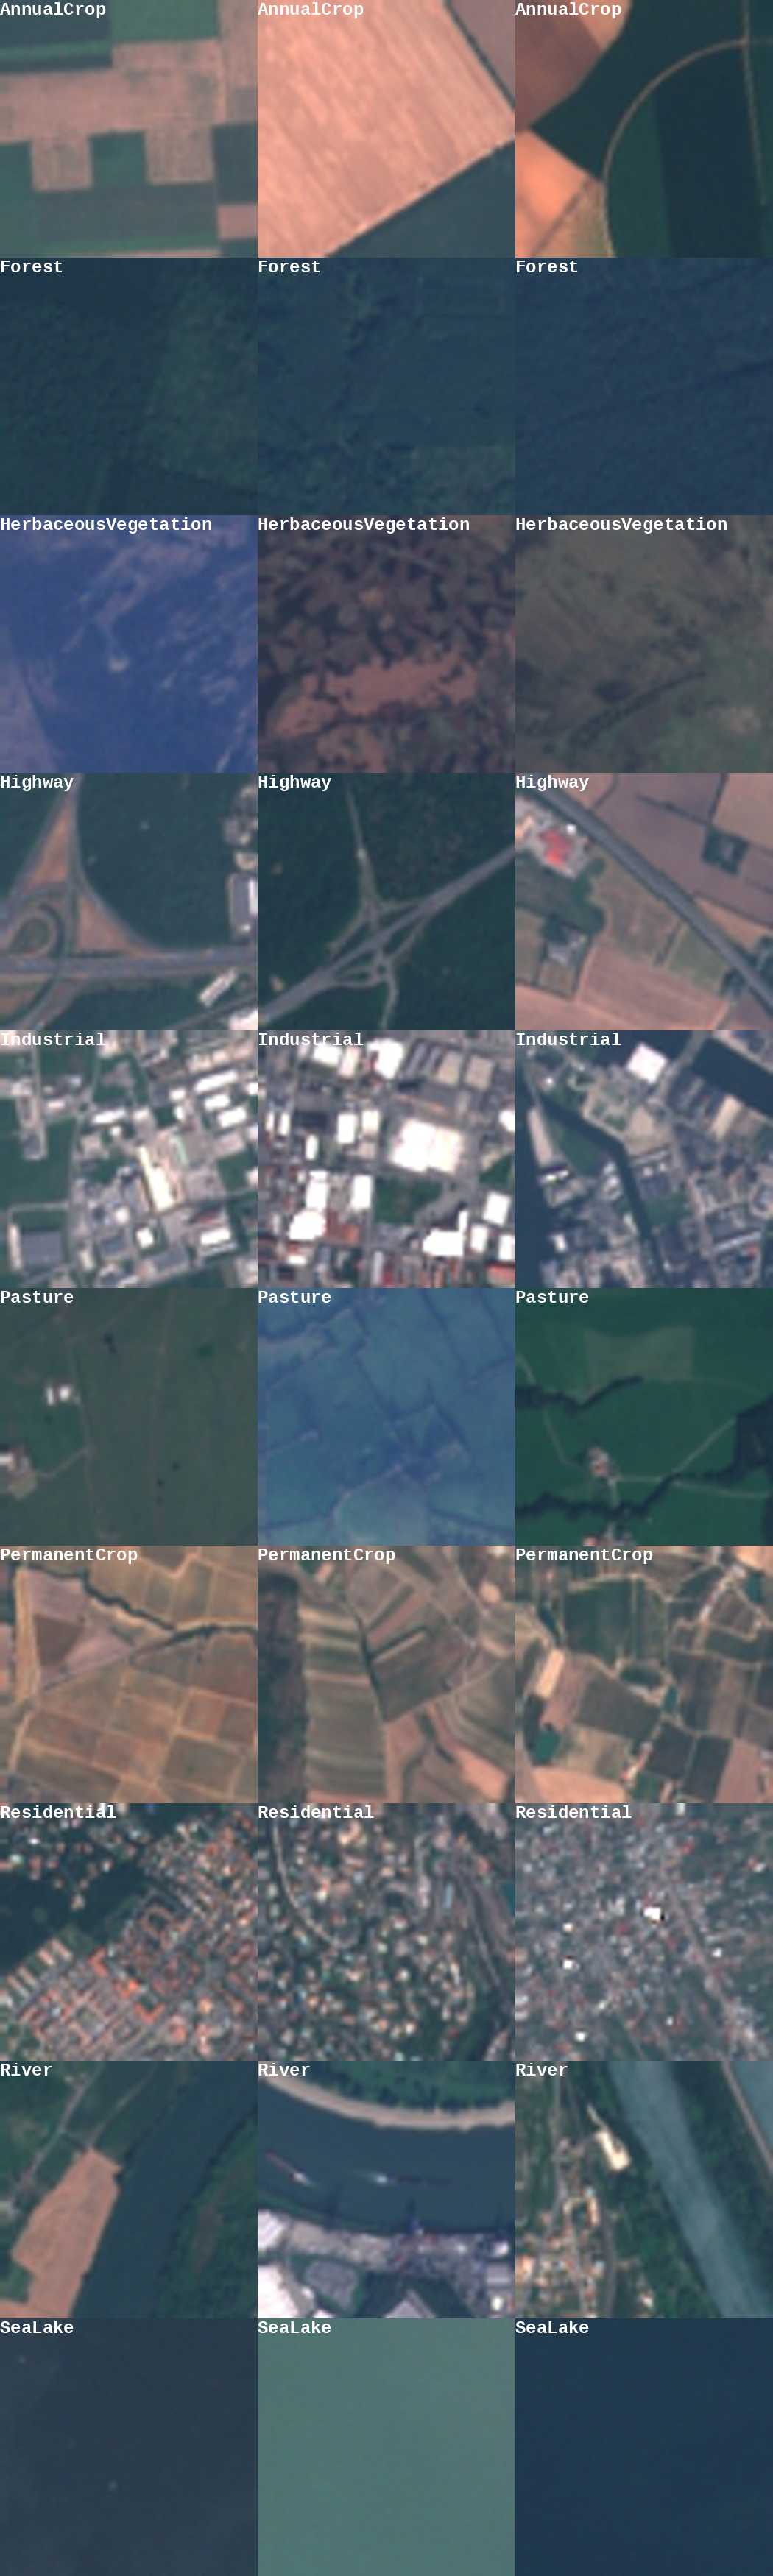

In [8]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor

In [44]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path)

If we print a feature extractor, we can see its configuration.

In [45]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Processing the Dataset

In [46]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be
applied in real time (on both samples and slices, as shown below)

# Training and Evaluation

### Define our data collator

In [47]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define evaluation metric

In [48]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Load the model:

In [50]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Thw warning tells us to train the model (as we were planning to).

Set up the training configuration.

Note that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [56]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  optim="adamw_torch"
)

Now, we are ready to start training!



In [57]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [58]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.092500,0.159758,0.960741
200,0.203600,0.162882,0.961481
300,0.290300,0.357788,0.914074
400,0.207600,0.295241,0.923704
500,0.141100,0.252778,0.934815
600,0.207400,0.196216,0.949630
700,0.107000,0.282786,0.934074
800,0.192600,0.183203,0.944444
900,0.221200,0.172165,0.958519
1000,0.175600,0.150223,0.965185


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 7015430798GF
  train_loss               =       0.0707
  train_runtime            =   0:56:13.90
  train_samples_per_second =       28.809
  train_steps_per_second   =        1.801


In [59]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9852
  eval_loss               =     0.0535
  eval_runtime            = 0:00:14.58
  eval_samples_per_second =     92.574
  eval_steps_per_second   =     11.589


Code for pushing to Hugging Face Hub (not used):

In [60]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

# Conclusion
The performance of the model is very close to the one reported in [1]: 98.52% vs 98.722% in the paper.

There are a few potential reasons for this difference:
1. Difference in the train-test-validation split
2. The use of ViT base, possibly [1] uses the large variant
3. Optimizer settings: no learning rate scheduler used, no hyperparameter tuning
4. Only 4 epochs

The first two points should be checked against the paper. We could apply a hyperparameter tuning & continue the training for more epochs to alleviate points 3. & 4. Moreover, the new [LION](https://huggingface.co/docs/trl/customization#use-lion-optimizer) optimizer could be tested as well.

# References

[1] Ivica Dimitrovski, Ivan Kitanovski, Dragi Kocev, Nikola Simidjievski, Current trends in deep learning for Earth Observation: An open-source benchmark arena for image classification,
ISPRS Journal of Photogrammetry and Remote Sensing, Volume 197, 2023, Pages 18-35, ISSN 0924-2716, https://doi.org/10.1016/j.isprsjprs.2023.01.014. (https://www.sciencedirect.com/science/article/pii/S0924271623000205)